# KHDLUD Team 10

Thành viên:<br>
Trần Quốc Long - 18120202
<br>Nguyễn Huy Danh - 1712318
<br>Trần Đức Anh - 18120280
<br>Du Chí Nhân - 18120492

# Setup & Import

In [ ]:
# data mount

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Lib
import gc, os, warnings
from multiprocessing import cpu_count
from tqdm import tqdm

import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

from keras.models import Model
from keras.layers import Dense, BatchNormalization,Dropout, Embedding, Flatten, Concatenate, Input
from keras.layers.core import Lambda
from keras import backend as K
from keras import optimizers
from keras.layers.advanced_activations import PReLU

from scipy.special import erfinv

warnings.filterwarnings('ignore')

In [ ]:
# const
INPUT = '/content/drive/MyDrive/KHDLUD/src/input/'
test_original_data  = INPUT + 'test.csv'
train_original_data = INPUT + 'train.csv'
sample_submission_file = INPUT + 'sample_submission.csv'
OUTPUT = '/content/drive/MyDrive/KHDLUD/src/output/'

# Giới thiệu

## Link cuộc thi

Kaggle competion:
https://www.kaggle.com/c/santander-customer-transaction-prediction#
    
Solution git:
https://github.com/KazukiOnodera/Santander-Customer-Transaction-Prediction

Golf src:
https://github.com/KazukiOnodera/santander-customer-transaction-prediction/blob/master/py/990_2nd_place_solution_golf.py

## Giới thiệu chủ đề

Tại Santander, sứ mệnh của chúng tôi là giúp mọi người và doanh nghiệp phát triển thịnh vượng. Chúng tôi luôn tìm cách giúp khách hàng hiểu được sức khỏe tài chính của họ và xác định những sản phẩm và dịch vụ nào có thể giúp họ đạt được các mục tiêu về tiền tệ của mình.

Nhóm khoa học dữ liệu của chúng tôi liên tục thử thách các thuật toán học máy và làm việc với cộng đồng khoa học dữ liệu toàn cầu để đảm bảo chúng tôi có thể xác định chính xác hơn các cách mới để giải quyết thách thức phổ biến nhất, các vấn đề phân loại nhị phân, chẳng hạn như:

Khách hàng có hài lòng không? 
Một khách hàng sẽ mua sản phẩm này? 
Khách hàng có thể trả khoản vay này không?

**Trong thử thách này, chúng tôi mời Kagglers giúp chúng tôi xác định khách hàng nào sẽ thực hiện một giao dịch cụ thể trong tương lai, bất kể số tiền đã giao dịch. Dữ liệu được cung cấp cho cuộc thi này có cấu trúc giống với dữ liệu thực mà chúng tôi có sẵn để giải quyết vấn đề này.**

## Cách tính điểm

Kết quả dự đoán là xác suất một khách hàng sẽ thực hiện giao dịch trong tương lai.

Đánh giá bằng độ đo [AUC](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc) (Area under the ROC curve) do sự mất cân bằng giữa 2 class 0 và 1

![](https://drive.google.com/uc?id=1AQao_oSCjvjByhUTOKuLIzIgv2_9mWiy)

# Giải pháp

## 1. Loại bỏ những giá trị giả

[Link tham khảo](https://www.kaggle.com/yag320/list-of-fake-samples-and-public-private-lb-split)

Input: Dữ liệu của tập test (do việc này có ảnh hưởng đến quá trình và kết quả sau khi train)

Output: Dữ liệu của tập test đã được loại bỏ dữ liệu giả (Fake Samples)

Mục đích: Sau khi kiểm tra tập test và tập train thì một điều bất cập đã được nhận ra là: Trong trong tập test có các giá trị độc nhất ở trên từng đặc trưng khác với tập train. Tác giả đã đoán rằng người ta đã sử dụng kĩ thuật sampling distributions (phân phối mẫu) từ dữ liệu mẫu thật trong thống kê để tạo ra một số mẫu tổng hợp trong dữ liệu test. Và chúng ta sẽ lọc đi những mẫu dữ liệu giả ấy vì những mẫu giả ấy sẽ không đóng vai trò tính điểm trong tập test chính thức.

Quy trình thực hiện: Dựa trên kiến thức về phân phối mẫu, tác giả đã nghĩ ra một cách để phân loại các dữ liệu giả đấy khi kiểm tra đó chính là

- Nếu 1 mẫu có ít nhất 1 đặc trưng mang giá trị độc nhất thì đó sẽ là mẫu thật

- Nếu 1 mẫu sau khi kiểm tra toàn bộ đều không có giá trị độc nhất thì đó chính là mẫu giả.


In [ ]:
%%time

te_ = pd.read_csv(test_original_data).drop(['ID_code'], axis=1).values

# unique_samples = []
unique_count = np.zeros_like(te_)
for feature in tqdm(range(te_.shape[1])):
    _, index_, count_ = np.unique(te_[:, feature], return_counts=True, return_index=True)
    unique_count[index_[count_ == 1], feature] += 1

real_samples_indexes = np.argwhere(np.sum(unique_count, axis=1) > 0)[:, 0]
synthetic_samples_indexes = np.argwhere(np.sum(unique_count, axis=1) == 0)[:, 0]

100%|██████████| 200/200 [00:06<00:00, 30.30it/s]

CPU times: user 12.9 s, sys: 523 ms, total: 13.4 s
Wall time: 14.3 s


In [ ]:
del te_, unique_count
gc.collect()

66

In [ ]:
# real data

print(len(real_samples_indexes))
real_samples_indexes

100000


array([     3,      7,     11, ..., 199995, 199996, 199999])

In [ ]:
# fake data

print(len(synthetic_samples_indexes))
synthetic_samples_indexes

100000


array([     0,      1,      2, ..., 199994, 199997, 199998])

## 2. Nghịch đảo và loại bỏ một số đặc trưng

[Link tham khảo 1](https://www.kaggle.com/sibmike/are-vars-mixed-up-time-intervals)

[Link tham khảo 2](https://www.kaggle.com/cdeotte/modified-naive-bayes-santander-0-899/notebook)

Input: Dữ liệu của tập test và tập train

Output: Dữ liệu đã drop và nghịch đảo một số đặc trưng
  
Mục đích: Cải thiện hiệu quả quá trình huấn luyện

Sau khi xem qua phân phối xác suất, ta thấy rằng chúng có hình dạng giống nhau chỉ khác scale hoặc là bị lật ngược lại. Vì vậy ta sẽ đưa chúng về cùng dạng để giúp cho mô hình học hiệu quả hơn.

Quy trình thực hiện: Chúng ta sẽ xác định những đặc trưng có cùng hình dạng nhưng bị ngược và lật lại bằng cách nhân với -1.

In [ ]:
%%time

train = pd.read_csv(train_original_data)
test  = pd.read_csv(test_original_data).drop(synthetic_samples_indexes)
        
X_train = train.iloc[:, 2:].values
y_train = train.target.values

X_test = test.iloc[:, 1:].values

X = np.concatenate([X_train, X_test], axis=0)
del X_train, X_test; gc.collect()

reverse_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 11, 15, 16, 18, 19, 22, 24, 25, 26,
                27, 29, 32, 35, 37, 40, 41, 47, 48, 49, 51, 52, 53, 55, 60, 61,
                62, 65, 66, 67, 69, 70, 71, 74, 78, 79, 82, 84, 89, 90, 91, 94,
                95, 96, 97, 99, 103, 105, 106, 110, 111, 112, 118, 119, 125, 128,
                130, 133, 134, 135, 137, 138, 140, 144, 145, 147, 151, 155, 157,
                159, 161, 162, 163, 164, 167, 168, 170, 171, 173, 175, 176, 179,
                180, 181, 184, 185, 187, 189, 190, 191, 195, 196, 199,]
                
for j in reverse_list:
    X[:, j] *= -1

drop_vars = [7,
            10,
            17,
            27,
            29,
            30,
            38,
            41,
            46,
            96,
            100,
            103,
            126,
            158,
            185]

var_len = 200 - len(drop_vars)

# drop
X = np.delete(X, drop_vars, 1)

CPU times: user 12.5 s, sys: 658 ms, total: 13.1 s
Wall time: 13.9 s


Before:

![](https://drive.google.com/uc?export=view&id=10WaUKsy0znLjyNuNwD5CyQu9ZKiJkZKo)

After:

![](https://drive.google.com/uc?export=view&id=1SVOB8U8O1PdDPuByR5Ao5wlrZw94TC0y)

Lý do các đặc trưng này bị loại bỏ: Vì khi xét xác suất có điều kiện với class 1 thì phân phối của chúng có hình dáng khác nhau và khác với các đặc trưng còn lại.

Theo như tác giả đã thử nghiệm, việc nghịch đảo thực sự giúp ích cho mô hình, và việc loại bỏ các đặc trưng không tác động quá lớn đến mô hình:

![](https://drive.google.com/uc?id=1mBe_AzoE76VMzuSb_dSZX-1nx9RGh7Ez)

![](https://drive.google.com/uc?id=1uK8QMBD5UH8k6jxxk1w8J6j-ADo-0NE6)



## 3. Standard Scaling

Input: Dữ liệu sau khi đã loại bỏ fake và reverse, drop

Output: Dữ liệu đã chuẩn hóa

Mục đích: Sau khi đã loại bỏ các mẫu fake và những giá trị gây nhiễu, chuẩn hóa dữ liệu sẽ giúp dễ dàng nhận ra các điểm dữ liệu bất thường. Ngoài ra, còn giúp tránh được những vấn đề do  sự khác biệt về độ đo, phục vụ cho việc unpivot ở bước 5

Quy trình thực hiện: 

In [ ]:
%%time

# scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)

CPU times: user 641 ms, sys: 5.93 ms, total: 647 ms
Wall time: 639 ms


## 4. Count round Encoding

Input: Output của bước 3

Output: Dữ liệu cũ + các cột đếm số lượng theo từng cột

Mục đích: Feature engineering, giúp cải thiện kết quả

Quy trình thực hiện:<br>
Count encoding - Với mỗi cột, đếm số lượng giá trị và tạo ra cột mới bằng cách ánh xạ: giá trị -> số lượng<br>
Count round encoding - Tương tự như 4 nhưng giá trị được làm tròn lần lượt là 1,2 và 3 chữ số thập phân rồi mới đếm

In [ ]:
# count encoding
X_cnt = np.zeros((len(X), var_len * 4))

for j in tqdm(range(var_len)):
    for i in range(1, 4):
        x = np.round(X[:, j], i+1)
        dic = pd.value_counts(x).to_dict()
        X_cnt[:, i+j*4] = pd.Series(x).map(dic)
    x = X[:, j]
    dic = pd.value_counts(x).to_dict()
    X_cnt[:, j*4] = pd.Series(x).map(dic)

100%|██████████| 185/185 [01:39<00:00,  1.87it/s]


In [ ]:
# raw + count feature
X_raw = X.copy() # rename for readable
del X; gc.collect()

X = np.zeros((len(X_raw), var_len * 5))
for j in tqdm(range(var_len)):
    X[:, 5*j+1:5*j+5] = X_cnt[:, 4*j:4*j+4]
    X[:, 5*j] = X_raw[:, j]

100%|██████████| 185/185 [00:04<00:00, 39.42it/s]


In [ ]:
del X_raw, X_cnt
gc.collect()

53

## 5. Unpivot tất cả các cột

Input: Output của bước 4

Output: Tạo ra 1 table mới với 3m7 x 6

Mục đích: Họ cho rằng giá trị các cột là độc lập với nhau và có thể dùng giá trị của 1 cột để dự đoán target nên họ unpivot, hỗ trợ dự đoán target vì họ đã thử và thấy có cải thiện kết quả

Thực hiện: Cứ mỗi biến sẽ là 6 cột (Raw_value, 4 cột đã encode, thuộc về cột nào) đem đi stack vào nhau

In [ ]:
#@title 
# treat each var as same
X_train_concat = np.concatenate([
    np.concatenate([
        X[:200000, 5*cnum:5*cnum+5], 
        np.ones((len(y_train), 1)).astype("int")*cnum
    ], axis=1) for cnum in range(var_len)], axis=0)
y_train_concat = np.concatenate([y_train for cnum in range(var_len)], axis=0)

In [ ]:
%%time

# Re-write

X_train_concat = np.concatenate([X[:200000, 0:5], np.zeros((200000, 1)).astype(np.uint8)], axis=1)
X_test = np.concatenate((X[200000:, 0:5], np.zeros((100000, 1)).astype(np.uint8)), axis=1)

for cnum in tqdm(range(1, var_len)):
    tmp = np.concatenate([X[:200000, 5*cnum:5*cnum+5], np.ones((200000, 1)).astype(np.uint8)*cnum], axis=1)
    X_train_concat = np.concatenate([X_train_concat, tmp], axis=0)
    tmp = np.concatenate((X[200000:, 5*cnum:5*cnum+5], np.ones((100000, 1)).astype(np.uint8)*cnum), axis=1)
    X_test = np.concatenate((X_test,tmp), axis=0)
    
y_train_concat = np.tile(y_train, var_len)

100%|██████████| 184/184 [01:01<00:00,  3.01it/s]

CPU times: user 59.8 s, sys: 3.01 s, total: 1min 2s
Wall time: 1min 1s


In [ ]:
# Kết quả sau khi tiền xử lý

show = pd.DataFrame(X_train_concat, columns = ['raw values', 'count_1', 'count_2', 'count_3', 'count_4','var'])
show

,raw values,count_1,count_2,count_3,count_4,var
0,0.575796,8.0,1093.0,122.0,14.0,0.0
1,-0.271663,3.0,973.0,87.0,6.0,0.0
2,0.679857,6.0,1015.0,94.0,14.0,0.0
3,-0.126794,3.0,1084.0,93.0,6.0,0.0
4,0.275857,8.0,1131.0,135.0,18.0,0.0
...,...,...,...,...,...,...
36999995,1.396420,2.0,527.0,39.0,6.0,184.0
36999996,-0.348698,2.0,1017.0,113.0,13.0,184.0
36999997,-0.718784,1.0,1101.0,116.0,17.0,184.0
36999998,1.016240,1.0,800.0,68.0,6.0,184.0


In [ ]:
del show, tmp
gc.collect()

62

Giải thích của tác giả:

![](https://drive.google.com/uc?id=1HN3ommg9DKeykNJjzpYomI2HaS_ETv1-)

- Giả sử độc lập có điều kiện: 
    - $P(X \mid Y=1) = P(x_1 \mid Y=1)*P(x_2 \mid Y=1)$ 
    - $P(X \mid Y=0) = P(x_1 \mid Y=0)*P(x_2 \mid Y=0)$

$\\[1em]$

- Nhưng ta **không** giả sử rằng: $P(x_1)*P(x_2)=P(X)$

$\\[1em]$

Thứ ta cần: $P(Y=1 \mid X) \\[1em]
= \frac{P(X \mid Y=1) \cdot P(Y=1)}{P(X)} \\[2em]
= \frac{P(x_1 \mid Y=1) \cdot P(x_2 \mid Y=1) \cdot P(Y=1)}{P(X)} \\[2em]
= \frac{P(Y=1 \mid x_1) \cdot P(Y=1 \mid x_2) \cdot P(x_1) \cdot P(x_2)}{P(X) \cdot P(Y=1)} \\[2em]$

$\Rightarrow$ Dự đoán Y không tốt vì nó phụ thuộc vào $\frac{P(x_1) \cdot P(x_2)}{P(X)}\\[1em]$

Nhưng với $\frac{P(Y=1 \mid X)}{P(Y=0 \mid X)}\\[1em]$ (Tỷ lệ - odds)

$= \frac{P(Y=1 \mid x_1) \cdot P(Y=1 \mid x_2) \cdot P(Y=0)}{P(Y=0 \mid x_1) \cdot P(Y=0 \mid x_2) \cdot P(Y=1)}$


![](https://drive.google.com/uc?id=1PR0P9HJ_lP9QCMXs7TYB1jLK_-AD_pvX)

[Bài viết được nhắc đến](https://www.kaggle.com/jiweiliu/fast-pdf-calculation-with-correlation-matrix)

## 6. Ví dụ đơn giản cho hiệu quả của việc tiền xử lý:

In [ ]:
#@title
# Dữ liệu ban đầu

example_data = {'c1' : [3, 4, 5],
                'c2' : [-3, -4, -5],
                'c3' : [-3, -4, -5],
                'target' : [0, 1, 1]}
example_df = pd.DataFrame(example_data)
example_df

,c1,c2,c3,target
0,3,-3,-3,0
1,4,-4,-4,1
2,5,-5,-5,1


In [ ]:
#@title
# Sau khi qua nghịch đảo, unpivot
example_data2 = {'raw_value' : [3, 4, 5]*3,
                 'var' : [1]*3 + [2]*3 + [3]*3,
                'target' : [0, 1, 1]*3}
example_df2 = pd.DataFrame(example_data2)
example_df2

,raw_value,var,target
0,3,1,0
1,4,1,1
2,5,1,1
3,3,2,0
4,4,2,1
5,5,2,1
6,3,3,0
7,4,3,1
8,5,3,1


Cây quyết định nếu như không nghịch đảo:

![](https://drive.google.com/uc?id=1PK7URGNZl8gDHle4j0zbFkI_7iUAc-Qc)

![](https://drive.google.com/uc?id=1c5stV5bFgHAVkaeL2k2fHmucUlvnUMnj)

Cây quyết định khi có nghịch đảo:

![](https://drive.google.com/uc?id=178IRFRWSsHplR_uu1HwSPlQOo1DZ5aMk)

## 7. Quá trình Training và Predict

Input: dữ liệu sau khi unpivot và được gán tên các cột vào

Output: các model sau khi được train

Mục đích: từ data sau khi đã chuẩn hóa, tạo ra các model, dùng các model này để dự đoán

Mô tả: Trong golf solution, tác giả train và predict sử dụng Gradient Boosting với framework LightBGM



### Về Gradient Boosting với framework LightGBM


***Gradient Boosting là gì?***


Gradient Boosting là thuật toán học máy, thường được dùng trong để hồi quy, phân loại và các tác vụ khác. Bản chất của GB là cố gắng tạo ra một phương pháp phân loại mạnh từ một số phương pháp phân loại yếu ( các cây quyết định ) . Điều này được thực hiện bằng cách xây dựng mô hình từ dữ liệu đào tạo, sau đó tạo ra một mô hình thứ hai cố gắng sửa lỗi từ mô hình đầu tiên. Các mô hình được thêm vào cho đến khi tập đào tạo được dự đoán hoàn hảo hoặc thêm một số mô hình tối đa.

nói đơn giản thì GB sẽ tạo lần lượt các cây quyết định, cây ban đầu có thể yếu, lỗi nhiều, các cây sau đó sẽ được xây dựng với mục đích giảm thiểu lỗi trên cây trước đó



***Light GBM là gì?***

Là một thuật toán thông dụng trong các cuộc thi trên Kaggle, với các ưu điểm như:

    Training nhanh hơn và hiệu quả hơn
    Ít tiêu thụ bộ nhớ
    Chính xác hơn
    Có hỗ trợ parallel, GPU,..
    ổn định để xử lý các bộ dữ liệu kích thước lớn

Trong khi đa số các thuật toán thúc đẩy ( boosting algorithm)  khác phát triễn cây theo chiều ngang ( level-wise tree growth) , LightGBM phát triễn cây theo chiều dọc (leaf-wise tree growth).

![](https://drive.google.com/uc?export=view&id=1A3Er0Ik-AVuFtzyqW4l0p8JqAVv4JM0J)


Chỗ này hiểu đơn giản thì level-wise tree growth tương tự như BFS, còn ***leaf-wise tree growth*** tương tự như DFS, sẽ mở rộng theo chiều dọc tại node cần thiết, nên là  so về hiệu quả trên cây quyết định thì leaf-wise tree growth sẽ tốt hơn cho các bộ dữ liệu kích thước lớn

### Config

In [ ]:
NFOLD = 10
NROUND = 1600
SEED = np.random.randint(99999)
np.random.seed(SEED)
params = {
    'bagging_freq': 5,              # tần suất bagging
    'bagging_fraction': 1.0,        ## dùng để tăng tốc training, có thể được dùng để giải quyết over-fitting
    'boost_from_average':'false',   # điều chỉnh điểm ban đầu thành giá trị trung bình của các nhãn để hội tụ nhanh hơn
    'boost': 'gbdt',                # Gradient Boosting Decision Tree truyền thống
    'feature_fraction': 1.0,        ## 1 nghĩa là LightGBM sẽ chọn toàn bộ feature trước khi training mỗi cây
                                    ## dùng để tăng tốc training, có thể được dùng để giải quyết over-fitting
    'learning_rate': 0.005,         
                                    # quá nhỏ: hội tụ về phía mức lỗi tối thiểu, tăng lượng thời gian cần thiết để đào tạo mô hình.
                                    # quá cao: Điều này sẽ làm cho quá trình training không ổn định, kết quả thiếu chính xác nhưng thời gian training nhanh hơn.
                                    
    'max_depth': -1,                ## giới hạn độ sâu tối đa cho cây. 
                                    # được sử dụng để đối phó với over-fitting khi dữ liệu nhỏ. -1 nghĩa là không giới hạn
    'metric':'binary_logloss',      ##
    'min_data_in_leaf': 30,         # số lượng dữ liệu tối thiểu trong một lá. Có thể được sử dụng để đối phó với over-fitting
    'min_sum_hessian_in_leaf': 10.0,# Giống như min_data_in_leaf, có thể được sử dụng để đối phó với over-fitting 
    'num_leaves': 64,               # số lượng lá tối đa trong một cây
    'num_threads': cpu_count(),     # sử dụng toàn bộ số lượng CPU trong hệ thống
    'tree_learner': 'serial',       # single machine tree learner
    'objective': 'binary',          # binary log loss classification
    'verbosity': -1                 # kiểm soát mức độ chi tiết của LightGBM
    }

### Phân chia dữ liệu cho 10-fold

Phần dữ liệu Training thì sẽ được chia ngẫu nhiên thành K phần (K trong bài toán đang sử dụng là 10). 

Phân thành 2 tập, 1 tập train và 1 tập validation dùng cho bước training


In [ ]:
%%time

train_group = np.arange(len(X_train_concat))%200000

id_y = pd.DataFrame(zip(train_group, y_train_concat), 
                    columns=['id', 'y'])

id_y_uq = id_y.drop_duplicates('id').reset_index(drop=True)

def stratified(nfold=5):
    
    id_y_uq0 = id_y_uq[id_y_uq.y==0].sample(frac=1)
    id_y_uq1 = id_y_uq[id_y_uq.y==1].sample(frac=1)
    
    id_y_uq0['g'] = [i%nfold for i in range(len(id_y_uq0))]
    id_y_uq1['g'] = [i%nfold for i in range(len(id_y_uq1))]
    id_y_uq_ = pd.concat([id_y_uq0, id_y_uq1])
    
    id_y_ = pd.merge(id_y[['id']], id_y_uq_, how='left', on='id')
    
    train_idx_list = []
    valid_idx_list = []
    for i in range(nfold):
        train_idx = id_y_[id_y_.g!=i].index
        train_idx_list.append(train_idx)
        valid_idx = id_y_[id_y_.g==i].index
        valid_idx_list.append(valid_idx)
    
    return train_idx_list, valid_idx_list

train_idx_list, valid_idx_list = stratified(NFOLD)

CPU times: user 49.1 s, sys: 3.3 s, total: 52.4 s
Wall time: 50.8 s


In [ ]:
%%time

# Re-write

id_y = pd.DataFrame(y_train_concat, columns=['y']).reset_index().rename(columns={'index':'id'})
id_y['id'] = id_y['id'] % 200000

id_y_uq = pd.DataFrame(y_train, columns=['y'])

CPU times: user 840 ms, sys: 5.02 ms, total: 845 ms
Wall time: 853 ms


In [ ]:
id_y_uq = pd.DataFrame(y_train, columns=['y']).reset_index().rename(columns={'index':'id'})
id_y = np.tile(id_y_uq.values, (3,1))
id_y = pd.DataFrame(id_y, columns=['id','y'])

In [ ]:
# Re-write

def stratified(nfold=5):
    skf = StratifiedKFold(n_splits=nfold,shuffle=True)

    for train_idx, valid_idx in skf.split(id_y_uq, id_y_uq['y']):
        yield (id_y[id_y['id'].isin(train_idx)].index, id_y[id_y['id'].isin(valid_idx)].index)

### Building model, training & predict

Train model K=10 lần, mỗi lần train sẽ chọn 1 phần làm dữ liệu validation và K-1 phần còn lại làm dữ liệu training.

Kết quả sau mỗi lần train sẽ lưu lại.

Kết quả đánh giá model cuối cùng sẽ là trung bình cộng kết quả đánh giá của K lần train trên.

In [ ]:
%%time

models = []
oof = np.zeros(len(id_y))
p_test_all = np.zeros((100000, var_len, NFOLD))

for i in tqdm(range(NFOLD)):
    print(f'Building {i}...')
    
    train_idx = train_idx_list[i]
    valid_idx = valid_idx_list[i]
    
    # train
    X_train_cv = X_train_concat[train_idx]
    y_train_cv = y_train_concat[train_idx]
    
    # valid
    X_valid = X_train_concat[valid_idx]
    
    
    print('gen Dataset')
    dtrain = lgb.Dataset(
        X_train_cv, y_train_cv, 
        feature_name=['value', 'count_org', 'count_2', 'count_3', 'count_4', 'varnum'], 
        categorical_feature=['varnum'], free_raw_data=False
    )

    print('Trainning....')
    model = lgb.train(params, train_set=dtrain, num_boost_round=NROUND, verbose_eval=100)

    model.save_model(f'{OUTPUT}Nhan_model{i}.txt', num_iteration=model.best_iteration)
    
    print('Predicting....')
    p_valid = model.predict(X_valid)
    p_test  = model.predict(X_test)
    for j in tqdm(range(var_len)):
        oof[valid_idx] = p_valid
        p_test_all[:, j, i] = p_test[j*100000:(j+1)*100000]
    '''
        my_model.booster_.save_model('mode.txt')
        #load from model:

        bst = lgb.Booster(model_file='mode.txt')
    '''

    models.append(model)

  0%|          | 0/10 [00:00<?, ?it/s]

Building 0...
gen Dataset
Trainning....
Predicting....



 10%|█         | 1/10 [12:15<1:50:20, 735.60s/it]

Building 1...
gen Dataset
Trainning....
Predicting....



 20%|██        | 2/10 [24:07<1:36:14, 721.83s/it]

Building 2...
gen Dataset
Trainning....
Predicting....



 30%|███       | 3/10 [35:59<1:23:40, 717.28s/it]

Building 3...
gen Dataset
Trainning....
Predicting....



 40%|████      | 4/10 [47:45<1:11:16, 712.74s/it]

Building 4...
gen Dataset
Trainning....
Predicting....



 50%|█████     | 5/10 [59:39<59:26, 713.33s/it]  

Building 5...
gen Dataset
Trainning....
Predicting....



 60%|██████    | 6/10 [1:11:24<47:21, 710.36s/it]

Building 6...
gen Dataset
Trainning....
Predicting....



 70%|███████   | 7/10 [1:23:16<35:32, 710.96s/it]

Building 7...
gen Dataset
Trainning....
Predicting....



 80%|████████  | 8/10 [1:35:08<23:42, 711.20s/it]

Building 8...
gen Dataset
Trainning....
Predicting....



 90%|█████████ | 9/10 [1:47:04<11:52, 712.65s/it]

Building 9...
gen Dataset
Trainning....
Predicting....



100%|██████████| 10/10 [1:59:04<00:00, 714.49s/it]

CPU times: user 2d 10h 23min 41s, sys: 1min 3s, total: 2d 10h 24min 45s
Wall time: 1h 59min 5s


In [ ]:
%%time

# Re-write

models = []
oof = np.zeros(len(id_y))
p_test_all = np.zeros((100000, var_len, NFOLD))

for i, (train_idx, valid_idx) in tqdm(enumerate(stratified(NFOLD)), total=NFOLD):
    print()
    # train
    X_train_cv = X_train_concat[train_idx]
    y_train_cv = y_train_concat[train_idx]
    
    # valid
    X_valid = X_train_concat[valid_idx]

    print('gen Dataset')
    dtrain = lgb.Dataset(
        X_train_cv, y_train_cv, 
        feature_name=['value', 'count_org', 'count_2', 'count_3', 'count_4', 'varnum'], 
        categorical_feature=['varnum'], free_raw_data=False
    )
    
    print('Training....')
    model = lgb.train(params, train_set=dtrain, num_boost_round=NROUND, verbose_eval=100)

    model.save_model(f'{OUTPUT}Nhan_model{i}.txt', num_iteration=model.best_iteration)
    
    print('Predicting....')
    p_valid = model.predict(X_valid)
    p_test  = model.predict(X_test)
    for j in tqdm(range(var_len)):
        oof[valid_idx] = p_valid
        p_test_all[:, j, i] = p_test[j*100000:(j+1)*100000]
    '''
        my_model.booster_.save_model('mode.txt')
        #load from model:

        bst = lgb.Booster(model_file='mode.txt')
    '''

    models.append(model)

  0%|          | 0/10 [00:00<?, ?it/s]


gen Dataset
Training....
Predicting....



 10%|█         | 1/10 [19:15<2:53:19, 1155.55s/it]


gen Dataset
Training....
Predicting....



 20%|██        | 2/10 [37:59<2:31:36, 1137.09s/it]


gen Dataset
Training....
Predicting....



 30%|███       | 3/10 [55:19<2:07:27, 1092.49s/it]


gen Dataset
Training....
Predicting....



 40%|████      | 4/10 [1:12:25<1:46:38, 1066.45s/it]


gen Dataset
Training....
Predicting....



 50%|█████     | 5/10 [1:29:24<1:27:25, 1049.14s/it]


gen Dataset
Training....
Predicting....



 60%|██████    | 6/10 [1:46:35<1:09:32, 1043.17s/it]


gen Dataset
Training....
Predicting....



 70%|███████   | 7/10 [2:03:43<51:54, 1038.25s/it]  


gen Dataset
Training....
Predicting....



 80%|████████  | 8/10 [2:20:46<34:26, 1033.17s/it]


gen Dataset
Training....
Predicting....



 90%|█████████ | 9/10 [2:38:05<17:15, 1035.10s/it]


gen Dataset
Training....
Predicting....



100%|██████████| 10/10 [2:55:10<00:00, 1051.05s/it]


CPU times: user 3d 18h 27min 35s, sys: 1min 42s, total: 3d 18h 29min 18s
Wall time: 2h 55min 10s


## 8. Chuyển kết quả predict sang tỉ lệ


Do data đã được ta thay đổi để train, bộ data lúc đưa vào training có kích thước là $(200k*200, 6)$, nên ta phải biến đổi kết quả này về lại kết quả như ban đầu

Tác giả sử dụng công thức:
\begin{align}
    \frac{9*p}{1-p}
\end{align}
và đưa về một bộ kết quả duy nhất.

Công thức được sử dụng ở trên đến từ thực nghiệm:
![](https://drive.google.com/uc?id=1mcjzRR5aSDrWM_chqYOFsX6W2p5j8a_E)

Kết hợp cùng với cách đánh giá dựa trên $AUC$, với $threshold >=0.500$ để ra được kết quả là tập submit cuối cùng.

In [ ]:
%%time

var_col = np.zeros((200000,),dtype=np.uint8)
for i in range(1,var_len):
    var_col = np.concatenate([var_col, (np.ones((200000,))*i).astype(np.uint8)])

id_y['var'] = var_col
id_y['pred'] = oof
oof = pd.pivot_table(id_y, index='id', columns='var', values='pred').values

p_test_mean = p_test_all.mean(axis=2)

p_test_odds = np.ones(100000) * 1 / 9
for j in tqdm(range(var_len)):
    if roc_auc_score(y_train, oof[:, j]) >= 0.500:
        p_test_odds *= (9 * p_test_mean[:, j] / (1 - p_test_mean[:, j]))

p_test_odds = p_test_odds / (1 + p_test_odds)

sub1 = pd.read_csv(sample_submission_file)
sub2 = pd.DataFrame({"ID_code":test.ID_code.values , "target":p_test_odds})
sub = pd.merge(sub1[["ID_code"]], sub2, how="left").fillna(0)

100%|██████████| 185/185 [00:15<00:00, 11.87it/s]


CPU times: user 52 s, sys: 3.16 s, total: 55.2 s
Wall time: 55.2 s


## 9. Submit kết quả

In [ ]:
%%time

sub.to_csv(OUTPUT + 'submit_file_2912.csv.gz', index=False, compression='gzip')

CPU times: user 1.56 s, sys: 5 ms, total: 1.57 s
Wall time: 1.58 s



Kết quả từ file golf của tác giả:

![](https://drive.google.com/uc?export=view&id=1ch8qcGijBZWVv_HduumZ07R34zyks0m6)

Kết quả các lần submit:

![](https://drive.google.com/uc?export=view&id=1FonZ8wHEBEEwr8TJgkS6bhrQSnAOqvgj)

![](https://drive.google.com/uc?id=1etf8al_OouxfLMfZzbPpNzTG1xUfkrwj)

## 10. Plot tree & model’s feature importances

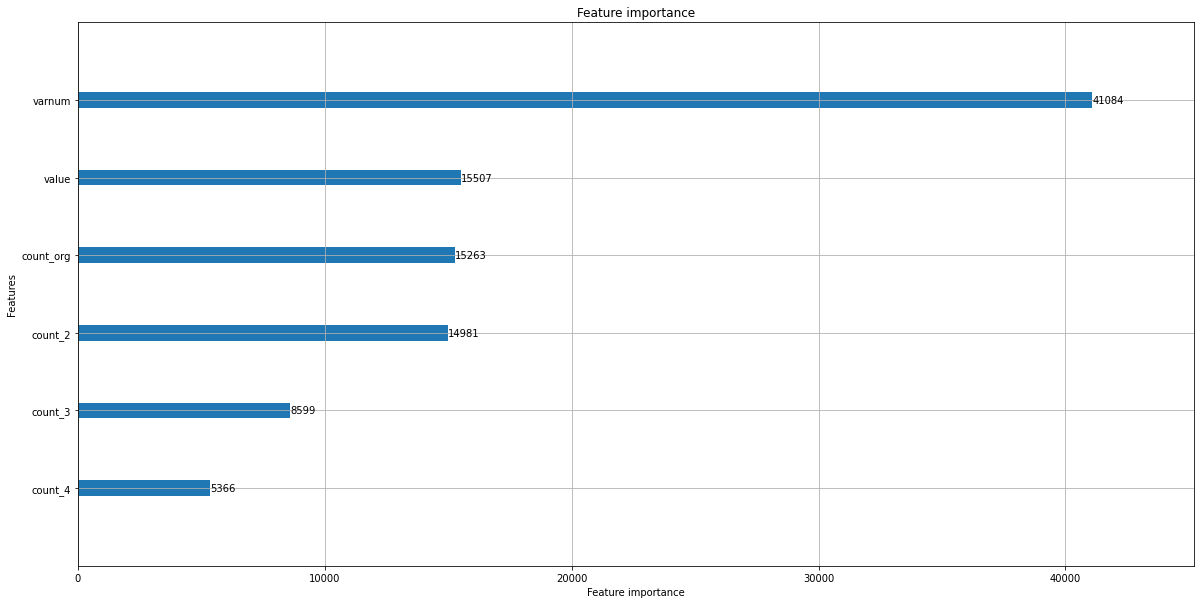

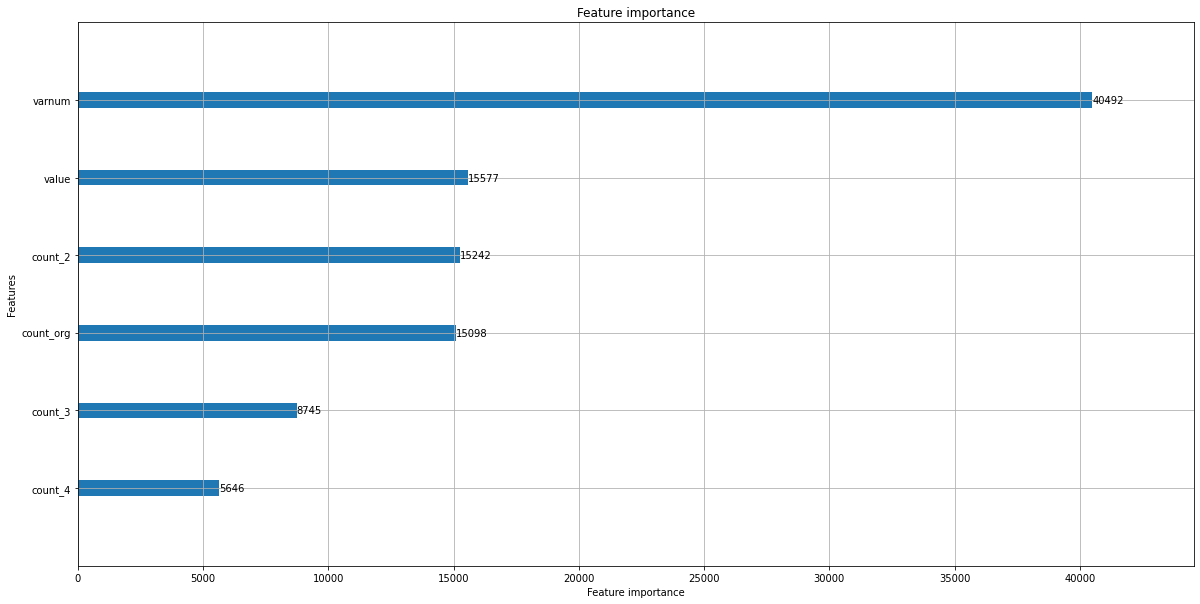

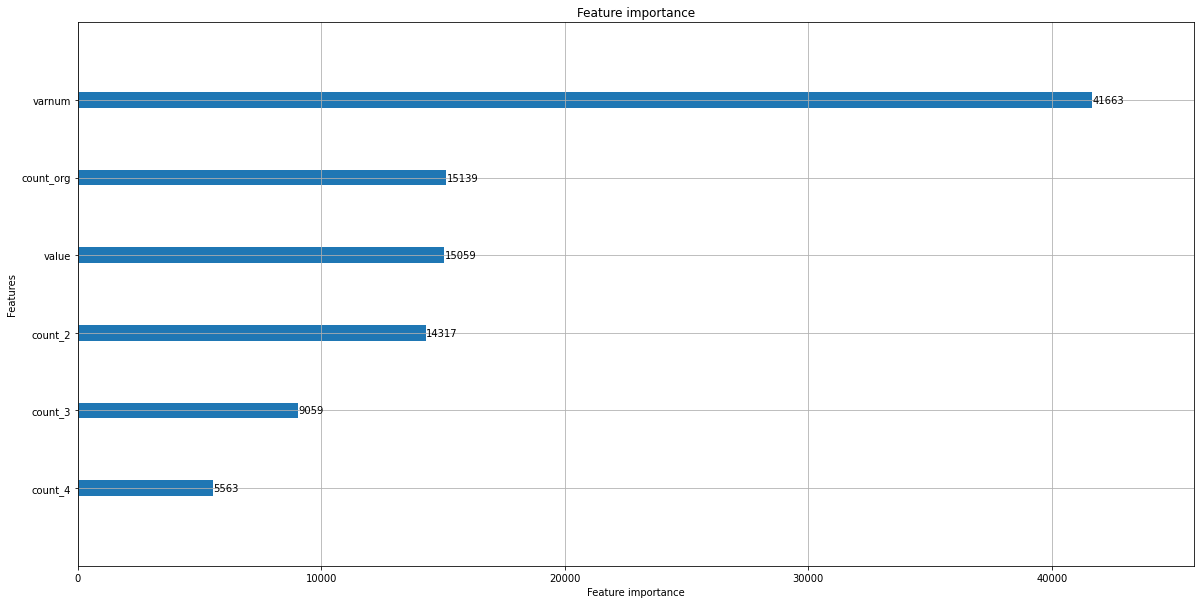

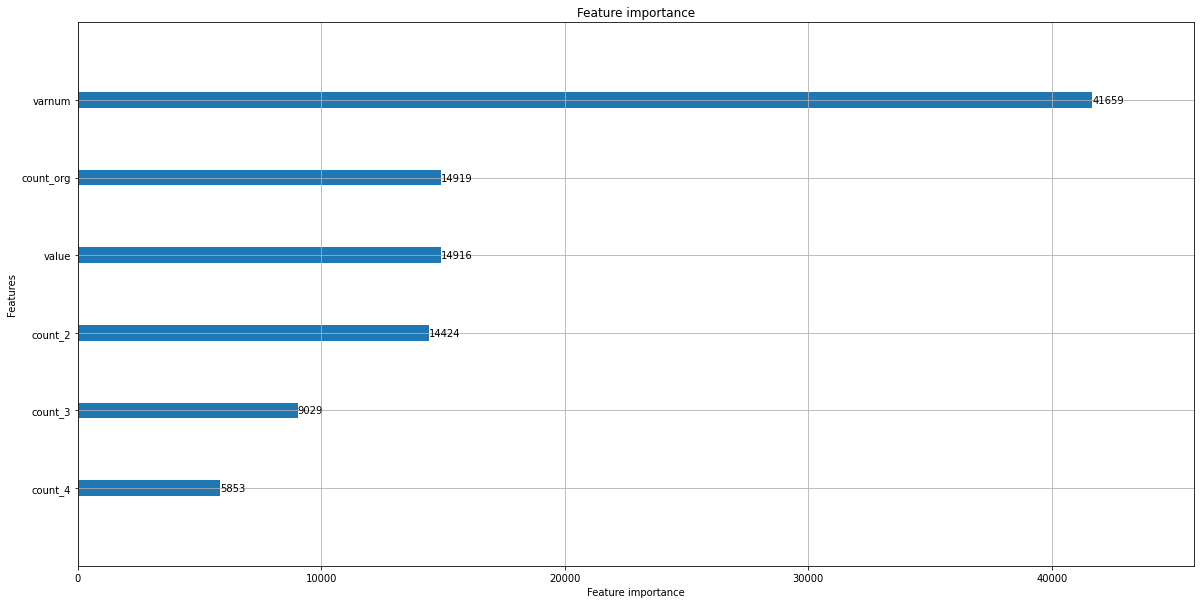

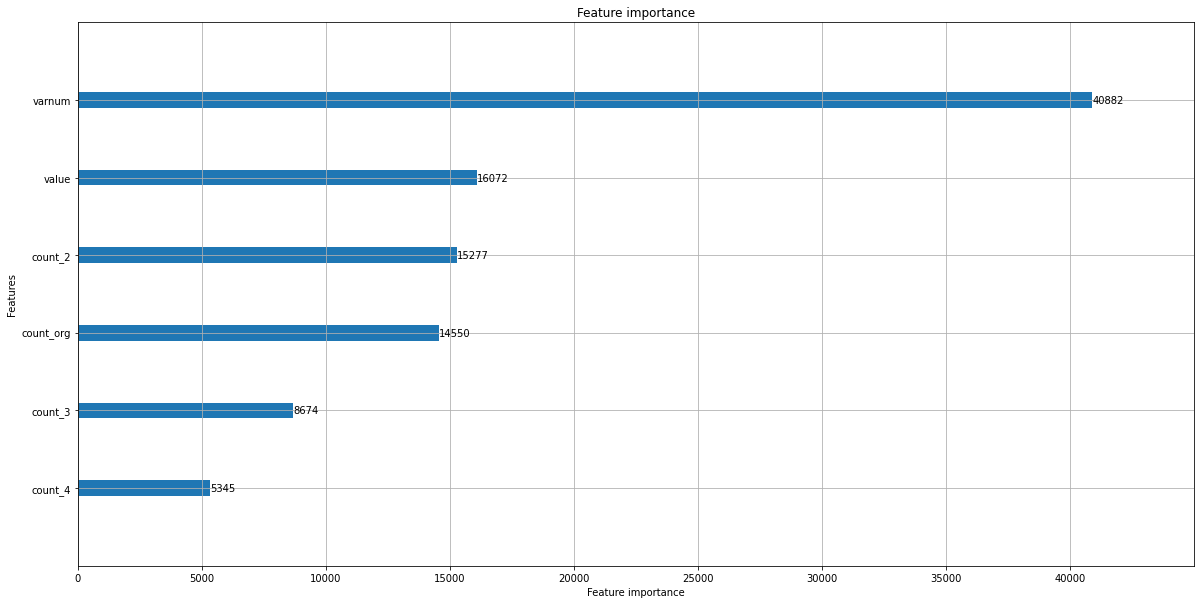

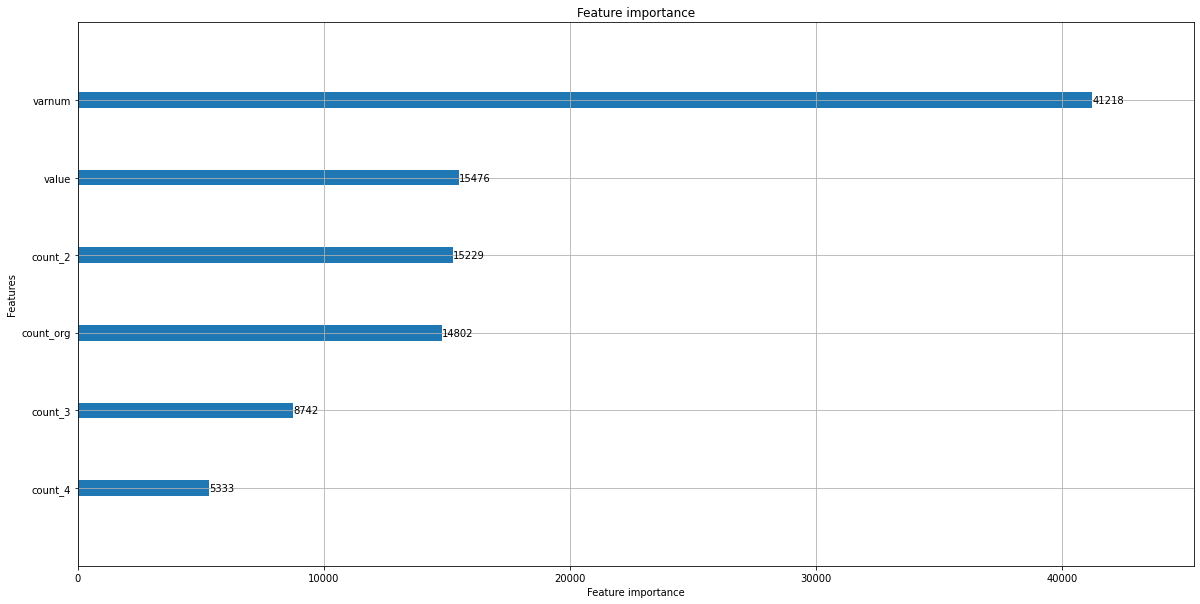

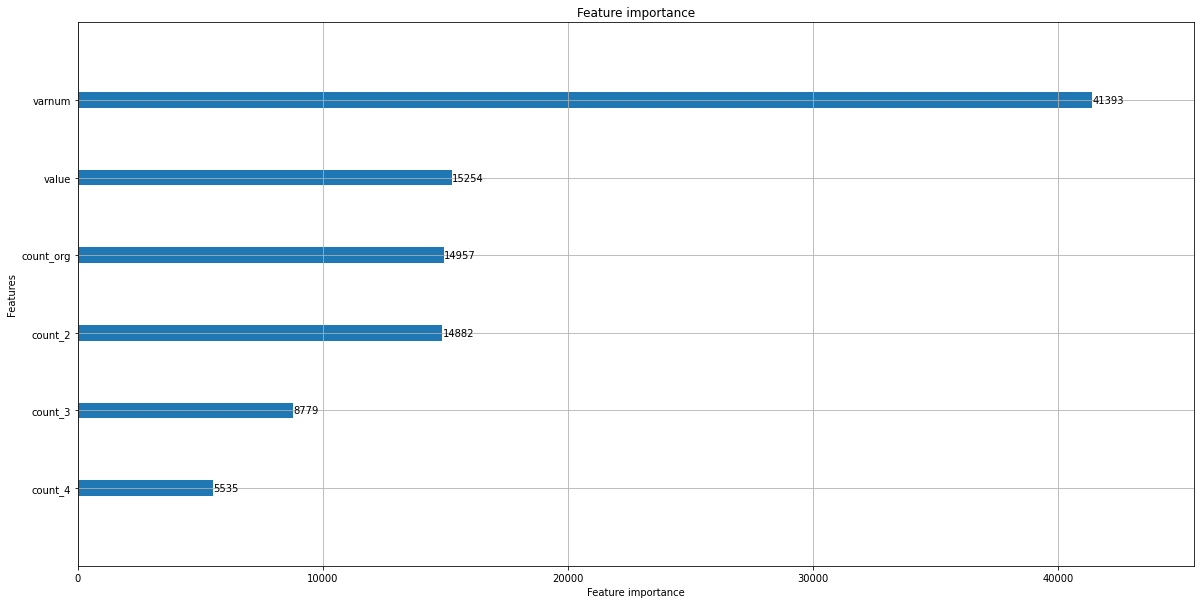

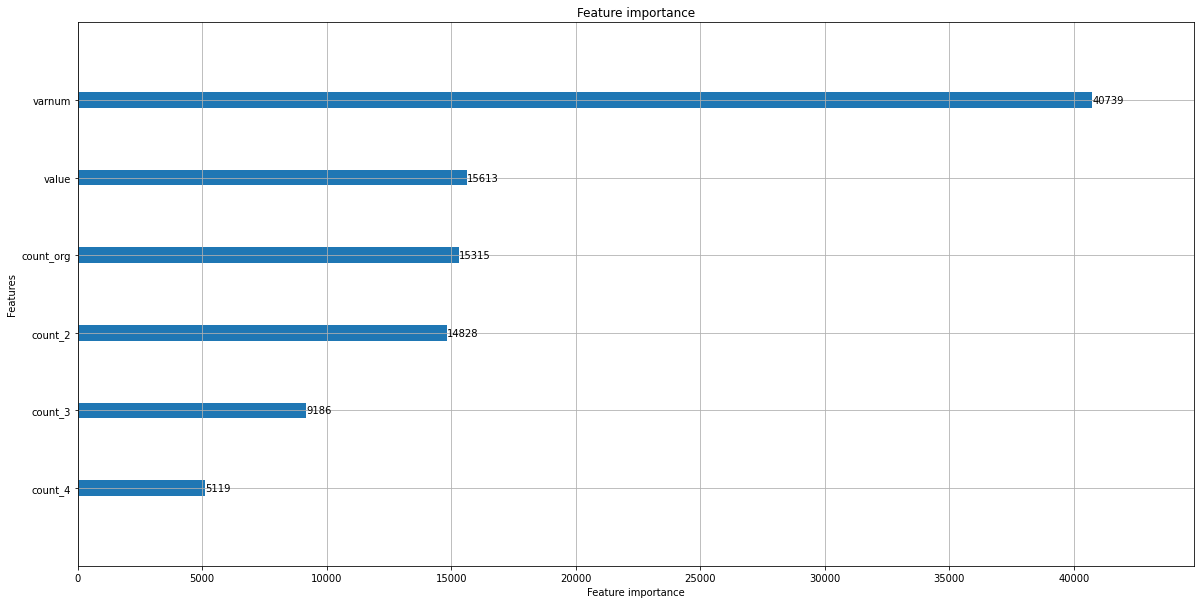

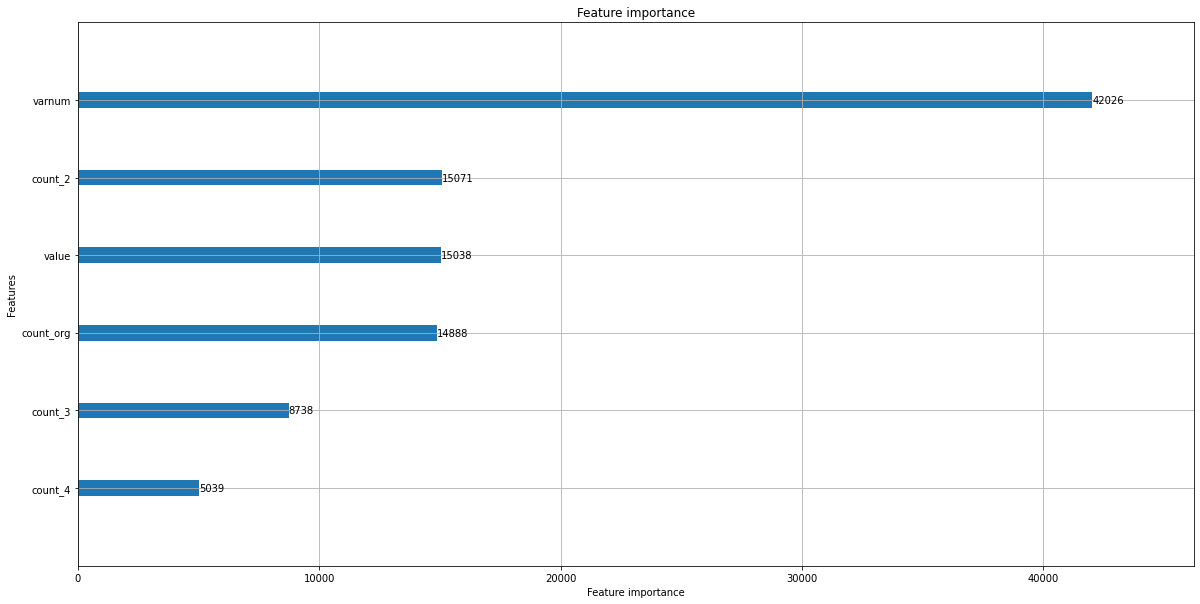

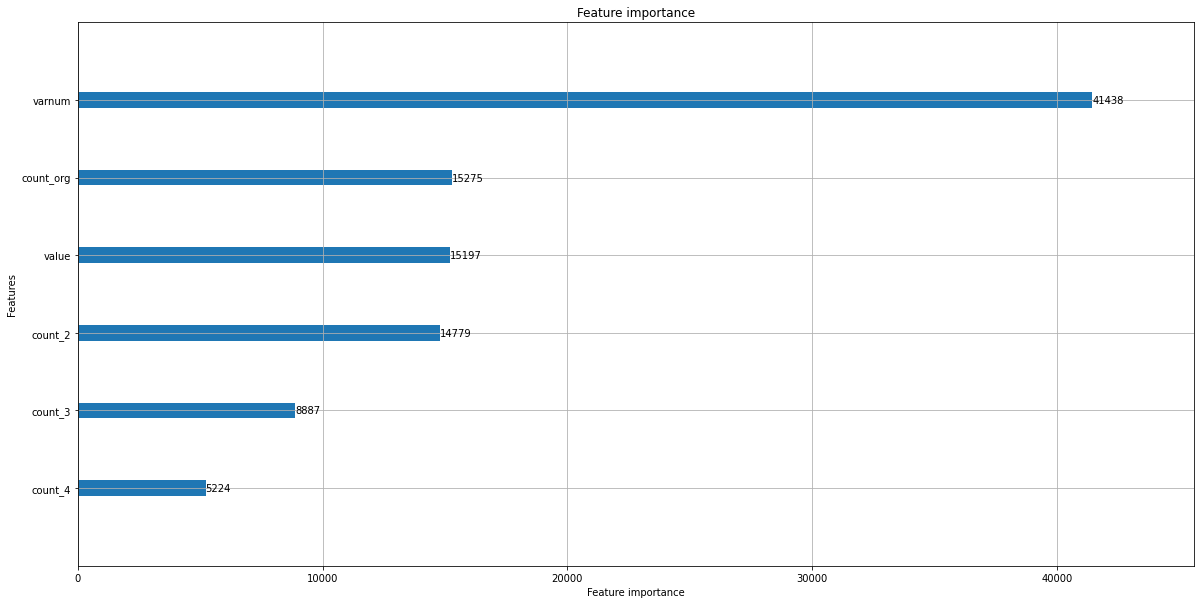

In [ ]:
for i in range(10):
    model = lgb.Booster(model_file=f'{OUTPUT}Nhan_model{i}.txt')

    fig, ax = plt.subplots(figsize=(20, 10))
    lgb.plot_importance(model, ax=ax)
    fig.savefig(f'{OUTPUT}Nhan_feature_importance{i}.jpg')

# Tài liệu tham khảo


*   https://www.noron.vn/post/tim-hieu-chi-tiet-ve-auc---roc-trong-machine-learning-1fz9nhqo5ut
*   https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html




